# Analyse MD simulation of ice

In [1]:
from watermodel import *

In [2]:
temp = 250
ice_type = 'Ih'
n_waters = 16

# path = ''
path = '/group/ag_cmb/scratch/minvernizzi/so3-flow/ice_MDdata/'
info = f'ice{ice_type}_T{temp}_N{n_waters}'
model = WaterModel.load_from_json(f'{path}model-{info}.json')
data = np.load(f'{path}MDtraj-{info}.npz')
pos = data['pos']
box = data['box']
ene = data['ene']

if model.is_box_orthorombic:
    box_edges = np.diagonal(box.squeeze())
    pos = ((pos/box_edges) % 1) * box_edges #force pbc
else:
    print('WARNING: you are working with a non-orthorombic box')

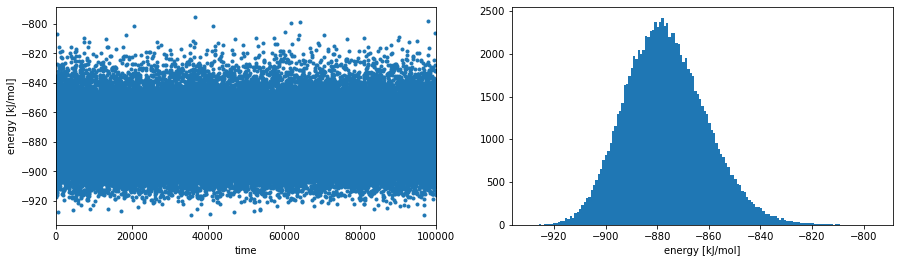

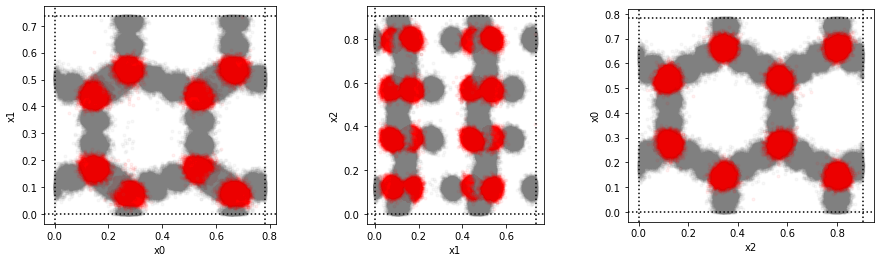

In [3]:
plot_energy(ene)
plot_2Dview(pos[::10], box[::10])